In [ ]:
# Without Heuristic Method

import sys
import math
from collections import Counter, defaultdict


def load_words(file):
    """Load five-letter words from a file, one per line."""
    with open("five_letter_words.txt") as f:
        words = [w.strip().lower() for w in f if len(w.strip()) == 5]
    return words


def evaluate_guess(solution, guess):
    """
    Compare guess to solution and return feedback string of length 5:
    'g' for green, 'y' for yellow, 'b' for black/gray.
    """
    feedback = [''] * 5
    sol_chars = list(solution)
    # First pass for greens
    for i, (g_char, s_char) in enumerate(zip(guess, solution)):
        if g_char == s_char:
            feedback[i] = 'g'
            sol_chars[i] = None  # remove matched char
    # Second pass for yellows/blacks
    for i, g_char in enumerate(guess):
        if feedback[i]:
            continue
        if g_char in sol_chars:
            feedback[i] = 'y'
            sol_chars[sol_chars.index(g_char)] = None
        else:
            feedback[i] = 'b'
    return ''.join(feedback)


def filter_candidates(candidates, guess, feedback):
    """
    Filter a list of candidate solutions based on the feedback for a guess.
    """
    filtered = []
    for word in candidates:
        if evaluate_guess(word, guess) == feedback:
            filtered.append(word)
    return filtered


def main():
    if len(sys.argv) < 2:
        print("Usage: python wordle_solver.py five_letter_words.txt")
        return
    candidates = load_words(sys.argv[1])
    print(f"Loaded {len(candidates)} candidate words.")

    while True:
        inp = input("Enter guess and feedback (e.g. crane gybgb), or 'quit': ")
        if inp.strip().lower() == 'quit':
            break
        try:
            guess, feedback = inp.split()
            guess = guess.lower()
            feedback = feedback.lower()
            candidates = filter_candidates(candidates, guess, feedback)
            print(f"{len(candidates)} candidates remaining.")
            print(candidates[:20])  # show top 20
        except Exception as e:
            print("Invalid input. Format: <guess> <feedback>")

if __name__ == '__main__':
    main()


Loaded 8913 candidate words.


Enter guess and feedback (e.g. crane gybgb), or 'quit':  tribe yybbb


110 candidates remaining.
['actor', 'altar', 'amort', 'antra', 'aorta', 'apart', 'aport', 'attar', 'carat', 'carts', 'chart', 'court', 'curst', 'darts', 'dorty', 'durst', 'farts', 'forth', 'forts', 'forty']


Enter guess and feedback (e.g. crane gybgb), or 'quit':  curst bbyyg


7 candidates remaining.
['short', 'skort', 'smart', 'snort', 'sport', 'start', 'swart']


Enter guess and feedback (e.g. crane gybgb), or 'quit':  snort gbggg


3 candidates remaining.
['short', 'skort', 'sport']


Enter guess and feedback (e.g. crane gybgb), or 'quit':  sport ggggg


1 candidates remaining.
['sport']


Loaded 8913 candidates.


Enter guess+feedback (e.g. crane gybgb), 'plot', or 'quit':  water yybby


16 candidates remaining.
['arrow', 'award', 'brawl', 'brawn', 'braws', 'crawl', 'craws', 'drawl', 'drawn', 'draws', 'dwarf', 'prawn', 'rowan', 'sward', 'swarf', 'swarm']
Top recommendations (heuristic): ['drawn', 'draws', 'drawl', 'brawn', 'braws']


Enter guess+feedback (e.g. crane gybgb), 'plot', or 'quit':  plot


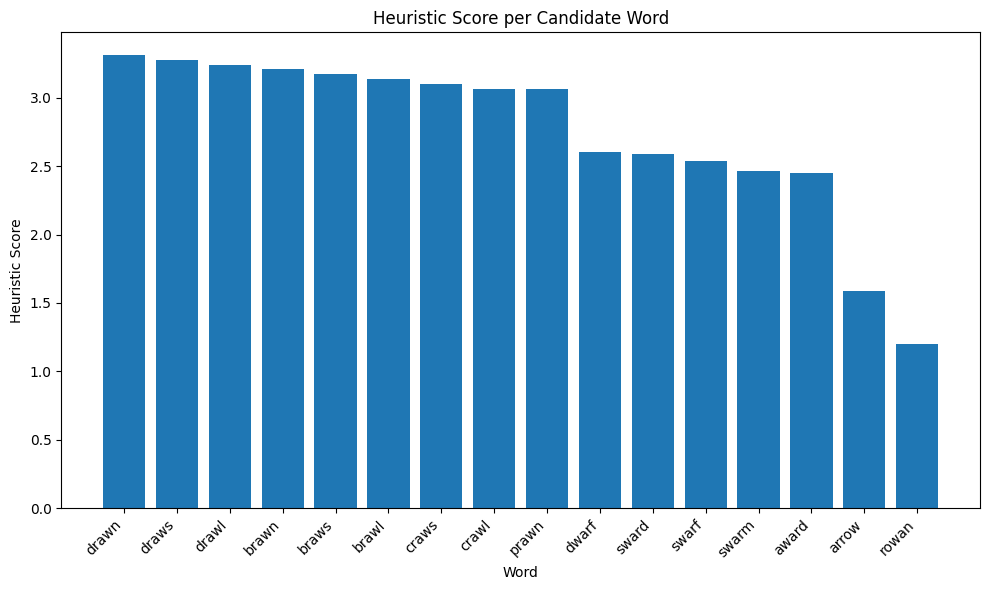

In [ ]:
#!/usr/bin/env python3
"""
A Wordle solver that:
- Loads a list of five-letter words
- Filters candidate answers based on Wordle feedback
- Recommends next guesses based on a frequency-based heuristic model
- Visualizes candidate scores with a bar chart mapping words to scores
"""
import sys
from collections import Counter
import matplotlib.pyplot as plt


def load_words(filepath):
    """Load five-letter words from a file, one per line."""
    with open("five_letter_words.txt") as f:
        return [w.strip().lower() for w in f if len(w.strip()) == 5]


def evaluate_guess(solution, guess):
    """Simulate Wordle feedback: 'g'=green, 'y'=yellow, 'b'=black."""
    feedback = [''] * 5
    sol_chars = list(solution)
    # Greens
    for i, (g_char, s_char) in enumerate(zip(guess, solution)):
        if g_char == s_char:
            feedback[i] = 'g'
            sol_chars[i] = None
    # Yellows/Blacks
    for i, g_char in enumerate(guess):
        if feedback[i]:
            continue
        if g_char in sol_chars:
            feedback[i] = 'y'
            sol_chars[sol_chars.index(g_char)] = None
        else:
            feedback[i] = 'b'
    return ''.join(feedback)


def filter_candidates(candidates, guess, feedback):
    """Keep only words consistent with the latest feedback."""
    return [w for w in candidates if evaluate_guess(w, guess) == feedback]


def compute_frequencies(candidates):
    """Compute positional and overall letter probabilities."""
    N = len(candidates)
    pos_counters = [Counter() for _ in range(5)]
    overall_counter = Counter()
    for w in candidates:
        for i, ch in enumerate(w):
            pos_counters[i][ch] += 1
            overall_counter[ch] += 1
    pos_freq = [{ch: cnt / N for ch, cnt in pc.items()} for pc in pos_counters]
    overall_freq = {ch: cnt / (5 * N) for ch, cnt in overall_counter.items()}
    return pos_freq, overall_freq


def score_word(word, pos_freq, overall_freq):
    """Compute heuristic score: positional match + unique-letter coverage."""
    score = sum(pos_freq[i].get(ch, 0) for i, ch in enumerate(word))
    for ch in set(word):
        score += overall_freq.get(ch, 0)
    return score


def recommend(candidates, top_n=5):
    """Return top_n candidate words by heuristic score."""
    pos_freq, overall_freq = compute_frequencies(candidates)
    scored = [(w, score_word(w, pos_freq, overall_freq)) for w in candidates]
    scored.sort(key=lambda x: x[1], reverse=True)
    return scored[:top_n]


def plot_word_scores(candidates):
    """Bar chart of heuristic scores per candidate word."""
    pos_freq, overall_freq = compute_frequencies(candidates)
    scored = [(w, score_word(w, pos_freq, overall_freq)) for w in candidates]
    # sort descending
    words_sorted, scores_sorted = zip(*sorted(scored, key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(max(10, len(words_sorted)*0.4), 6))
    plt.bar(range(len(words_sorted)), scores_sorted)
    plt.xticks(range(len(words_sorted)), words_sorted, rotation=45, ha='right')
    plt.title("Heuristic Score per Candidate Word")
    plt.xlabel("Word")
    plt.ylabel("Heuristic Score")
    plt.tight_layout()
    plt.show()


def main():
    if len(sys.argv) < 2:
        print("Usage: python wordle_solver.py five_letter_words.txt")
        return
    candidates = load_words(sys.argv[1])
    print(f"Loaded {len(candidates)} candidates.")

    while True:
        inp = input("Enter guess+feedback (e.g. crane gybgb), 'plot', or 'quit': ")
        cmd = inp.strip().lower()
        if cmd == 'quit':
            break
        if cmd == 'plot':
            plot_word_scores(candidates)
            continue
        try:
            guess, feedback = cmd.split()
            candidates = filter_candidates(candidates, guess, feedback)
            print(f"{len(candidates)} candidates remaining.")
            print(candidates[:20])
            recs = recommend(candidates, top_n=5)
            print("Top recommendations (heuristic):", [w for w, s in recs])
        except ValueError:
            print("Invalid input. Use '<guess> <feedback>', 'plot', or 'quit'.")

if __name__ == '__main__':
    main()